In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d


In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "drive/My Drive/Colab Notebooks/ADA_replication_P4"

/content/drive/My Drive/Colab Notebooks/ADA_replication_P4


In [ ]:
from process_functions import *

### General overview:
- In this replication, the main problem was the memory management (and Pnull).  
- I worked with google colab (12gb ram) since my personal computer was too slow (8gb ram and hard disk hdd).  
- I tried to make the most optimized code possible in order to use the most possible of the data.  
- With this procedure, I could use all of the data.  
Some choices had to be made and I preffered to have a bad time complexity in order to prioritize space complexity.  
- There is not much visualizations of the dataframe as all the code is made in functions that call each other in order to take the least possible memory
- I chose to keep the main function on the notebook (`get_final_df`, `get_Pdata`,`get_Pnull`). Other functions used can be found in the file `process_functions.py`

### General informations about code:
- `get_final_df` is the main function : it is the function I call and it returns the needed vectors to do my plots.
- `get_Pnull` is the function I call to have Pnull
- `get_Pdata` is the function I call to have Pnull
- `get_Pnull` and `get_Pdata` both return a tuple (distance , y vector)
- `process_functions.py` contains functions I already used for P2 and new functions coded for P4
- New functions coded for P4 in the file `process_functions.py`:  
1) `get_dist_from_home` : used to compute the distance between checkin and home of each user. This is where I load the checkin_dataframe. This function then returns two separate dataframes used to compute Pnull and Pdata  
2) `Bool_visited_friend` : function that returns a boolean : used in an aggregation after a groupby in `get_Pdata`  
3) `apply_median` : apply moving median on vector in order to smooth curve  
4) `get_approximation` : used to interpolate values for plotting curves. Calls `apply_median` and returns a vector ready to be plotted


In [ ]:
#get paths
BRIGHTKITE_CHECKIN_PATH = os.path.join("data","loc-brightkite_totalCheckins.txt.gz")
BRIGHTKITE_EDGES_PATH = os.path.join("data","loc-brightkite_edges.txt.gz")
GOWALLA_CHECKIN_PATH = os.path.join("data","loc-gowalla_totalCheckins.txt.gz")
GOWALLA_EDGES_PATH = os.path.join("data","loc-gowalla_edges.txt.gz")


In [ ]:
def get_Pnull (homes_checkins_df):
    """
    function that returns Pnull
    Since there was no much hints on how to compute Pnull, I chose the following method:
    i) Compute total number of checkins for a given latitude and longitude (counts_tot)
    ii) Compute total number of checkins for a givendistance from home, latitude and longitude (counts_each)
    iii) Merge two dataframes (counts_tot and counts_each) on their latitude and logitude 
    iv) Groupby distance and compute fraction of counts_each/total of counts_tot
    """
    df=homes_checkins_df
    #'User x' is used for the count, then we rename it to a meaningful name
    counts_lon_lat_only=df.groupby(['checkin latitude x','checkin longitude x'],as_index=False).\
              count()[['checkin longitude x','checkin latitude x','User x']].\
              rename(columns={'User x':'counts each'})
    counts_lon_lat_dist=df.groupby(['distance from home x(km)','checkin latitude x','checkin longitude x'],as_index=False).\
                count() [['User x','distance from home x(km)','checkin longitude x','checkin latitude x']].\
                rename(columns={'User x':'counts tot'})

    #We work with the same dataframe in order to preserve memory and work inplace
    counts_each=pd.merge(counts_lon_lat_dist,counts_lon_lat_only,on=['checkin latitude x','checkin longitude x'])
    
    #compute the probability    
    tmp=counts_each.groupby('distance from home x(km)',as_index=False).sum().sort_values(by='distance from home x(km)')

    return tmp['distance from home x(km)'],tmp['counts each']/sum(tmp['counts tot'])


def get_Pdata (homes_df,homes_checkins_df,edges_df,numb_pieces=50):
    """
    I) Merge the three datasets : homes_df, edges_df, dist_from_home_df together
    Since the merge takes much memory, we proceed by chunks 
    The parameter numb_pieces lets us specify the number of number of chunks we want to work with
    For each chunk, we do 2 merges:
    i) merge distance from home dataframe with the edges 
    ii) merge with the dataframe that contains the homes of users

    II) Return different columns of the dataframe depending on the needed columns:
    For Pdata : we only need 3 columns :'distance from home x(km)','x in y home','User x_x'

    
    III) For each distance and for for each user, the user either visited a friend or not
    ==> We first groupby those two columns
    Once we know whether a certain user and for a certain distance did visit or not a friend,
    we groupby the distance only and we divide the number of visits to friends by the total number of checkins to get the Pdata

    Pdata corresponds to the ratio of the number of checkins for each user divided by the total number of checkins
    """
    df1=pd.DataFrame()
    length_pieces=homes_checkins_df.shape[0]//numb_pieces

    for i in range (numb_pieces):
        tmp=pd.merge(homes_checkins_df[length_pieces*i:length_pieces*(i+1)],edges_df,on='User x').\
               merge(homes_df,left_on='User y',right_on='User x').\
               rename(columns={'longitude home x': 'longitude home y','latitude home x':'latitude home y','User x_x':'numb checkins'})\
               [['checkin latitude x','checkin longitude x','latitude home y','longitude home y','distance from home x(km)','numb checkins']]
        #returns True or False, will be used as 0/1 after
        tmp['x in y home']=calculate_distance (tmp['checkin latitude x'],tmp['checkin longitude x'],tmp['latitude home y'],tmp['longitude home y'])<=25

        df1=df1.append(tmp[['distance from home x(km)','x in y home','User x_x']])
    #df1=merge_and_return(homes_df,homes_checkins_df,edges_df,numb_pieces=100)
    df1=df1.groupby(['User x_x','distance from home x(km)'],as_index=False).agg({'x in y home':Bool_visited_friend},axis='columns').\
                          groupby('distance from home x(km)',as_index=False).agg({'x in y home':'sum','numb checkins':'size'},axis='columns').\
                          sort_values(by='distance from home x(km)')
    print('finished Pdata')
    return df1['distance from home x(km)'],df1['x in y home']/df1['numb checkins']

def get_final_df (CHECKIN_PATH, EDGES_PATH):
    """
    main function
    INPUTS:
    data paths : checkin path and edges path
    OUTPUTS:
    The three needed vectors needed to plot
    1) distances vector: will be x-axis
    2) Pdata vector
    3) Pnull vector
    The output is of this form : ((distances vector Pdata,Pdata vector),(distances vector Pnull,Pnull vector))
    """
    #names of the columns
    names_edges=["User x", "User y"]
    names_checkin=["User", "check-in time", "latitude", "longitude","location id"]

    #import edges dataset
    edges_df=pd.read_csv(EDGES_PATH,compression='gzip',delimiter='\t',error_bad_lines=False,warn_bad_lines=False,names=names_edges,skipinitialspace=True,index_col=None).astype(int)

    #call 'get_dist_from_home' (function can be found in process_functions.py)
    homes_df,homes_checkins_df=get_dist_from_home(CHECKIN_PATH,names_checkin)
    
    return get_Pdata(homes_df,homes_checkins_df,edges_df),get_Pnull(homes_checkins_df)


In [ ]:
P_data_gowalla_vectors,P_null_gowalla_vectors=get_final_df(GOWALLA_CHECKIN_PATH,GOWALLA_EDGES_PATH)

finished Pdata


In [ ]:
P_data_brightkite_vectors,P_null_brightkite_vectors=get_final_df(BRIGHTKITE_CHECKIN_PATH,BRIGHTKITE_EDGES_PATH)

finished Pdata


In [ ]:
distances_log=np.logspace(np.log10(25),4.05,17)


Text(0.5, 1.0, 'Pdata and Pnull of each dataframe as a function of the distance')

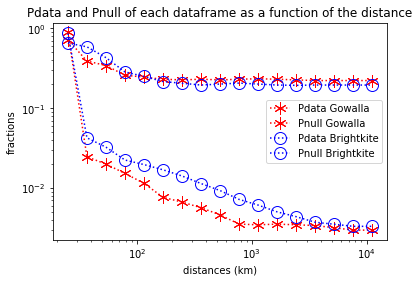

In [ ]:
# Gowalla
marker_style_gowalla = dict(color='r', linestyle=':', marker=(6, 2, 0),markersize=12)

P_data_gowalla_approx=get_approximation(P_data_gowalla_vectors[0],P_data_gowalla_vectors[1],distances_log,N=4)
plt.loglog(distances_log,P_data_gowalla_approx,\
           **marker_style_gowalla,markevery=0.03,label='Pdata Gowalla')
plt.legend()
P_null_gowalla_approx=get_approximation(P_null_gowalla_vectors[0],P_null_gowalla_vectors[1],distances_log,N=2)
plt.loglog(distances_log,P_null_gowalla_approx,\
           **marker_style_gowalla,markevery=0.03,label='Pnull Gowalla')
plt.legend()

# Brightkite
marker_style_brightkite = dict(color='blue', linestyle=':', marker='o',markersize=12,fillstyle='none')

P_data_brightkite_approx=get_approximation(P_data_brightkite_vectors[0],P_data_brightkite_vectors[1],distances_log,kind='nearest',N=4)
plt.loglog(distances_log,P_data_brightkite_approx,\
           markevery=0.01, **marker_style_brightkite,label='Pdata Brightkite')
plt.legend()
P_null_brightkite_approx=get_approximation(P_null_brightkite_vectors[0],P_null_brightkite_vectors[1],distances_log,N=2)
plt.loglog(distances_log,P_null_brightkite_approx,\
           markevery=0.01, **marker_style_brightkite,label='Pnull Brightkite')
plt.legend()

plt.xlabel('distances (km)')
plt.ylabel('fractions')
plt.title('Pdata and Pnull as a function of the distance')

Text(0.5, 1.0, 'Pdata/Pnull as a function of the distance')

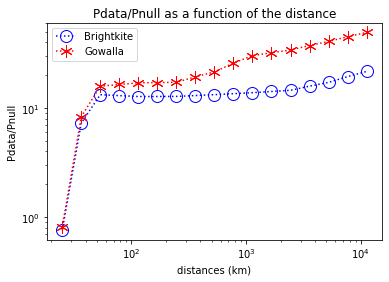

In [ ]:
plt.loglog(distances_log,apply_median(P_data_brightkite_approx/P_null_brightkite_approx,N=1),\
           markevery=0.01, **marker_style_brightkite,label='Brightkite')
plt.loglog(distances_log,apply_median(P_data_gowalla_approx/P_null_gowalla_approx,N=1),\
           **marker_style_gowalla,markevery=0.03,label='Gowalla')
plt.legend()

plt.xlabel('distances (km)')
plt.ylabel('Pdata/Pnull')
plt.title('Pdata/Pnull as a function of the distance')

**Comments on my replication:**
- The replication of Pdata is the same as the one in the paper (fig 3a). However, the instructions for Pnull being very unclear, my mode of computing Pnull gave different results as the one found in the paper.
- In my results, we see a big augmentation in the fraction Pdata/Pnull until a distance of approximately 80 km. Then, the fraction still increases but with a smaller slope.
- This means that the difference a friend makes on a user's movement increases fastly for small distances then increases more slowly.


**Limits of the paper in the replication**:  
One limit in the plot is that it doesn't take into account the time of checkin or maybe if the user checked in in the same time as his friend. In fact, we consider someone checked ina friends' house without even checkin if his friend was there. A better approach would have been to use the time of checkins and derive a better approach.
